In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def load_dataset(data_dir, img_height, img_width, batch_size, validation_split=0.2):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset='training',
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset='validation',
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    )

    return train_ds, val_ds

def build_model(img_height, img_width, num_classes):
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )
    base_model.trainable = False  

    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

def train_model(model, train_ds, val_ds, epochs):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=3,
        verbose=1,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping]
    )

    return history

# Preprocess training and validation datasets
def preprocess_dataset(dataset):
    def preprocess(image, label):
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        return image, label
    return dataset.map(preprocess)
    
def save_model(model, save_path):
    model.save(save_path)


In [2]:

data_dir = '/kaggle/input/faulty-solar-panel-images/Faulty_solar_panel'
img_height, img_width = 224, 224
batch_size = 32
num_classes = 6
epochs = 20

In [3]:
train_ds, val_ds = load_dataset(data_dir, img_height, img_width, batch_size)

Found 4372 files belonging to 6 classes.
Using 3498 files for training.
Found 4372 files belonging to 6 classes.
Using 874 files for validation.


In [4]:
# Preprocess the datasets
train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

In [5]:
model = build_model(img_height, img_width, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
history = train_model(model, train_ds, val_ds, epochs)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.3924 - loss: 1.6430 - val_accuracy: 0.7689 - val_loss: 0.6710
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.7367 - loss: 0.7325 - val_accuracy: 0.8066 - val_loss: 0.5252
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7843 - loss: 0.6036 - val_accuracy: 0.8444 - val_loss: 0.4574
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.8323 - loss: 0.4981 - val_accuracy: 0.8535 - val_loss: 0.4190
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.8478 - loss: 0.4496 - val_accuracy: 0.8650 - val_loss: 0.3870
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.8584 - loss: 0.4048 - val_accuracy: 0.8707 - val_loss: 0.3698
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8668 - loss: 0.3790 - val_accuracy: 0.8673 - val_loss: 0.3571
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.8810 - loss: 0.3579 - val_ac

In [7]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8995 - loss: 0.2933
Validation Accuracy: 90.96%


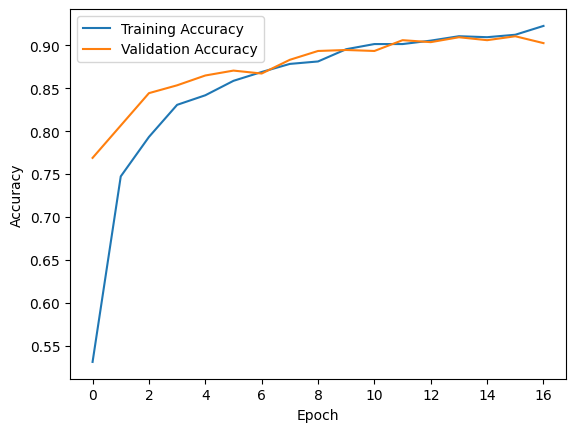

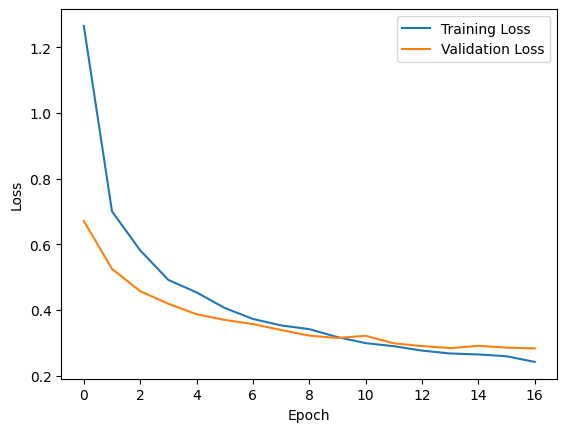

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
save_model(model, 'solar_panel_modeltry.h5')

In [10]:
# Load the model
loaded_model = tf.keras.models.load_model('solar_panel_modeltry.h5')

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
# Define class labels
class_labels = ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

In [12]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  #
    return img_array

In [13]:
def predict_image(img_path):
    img_array = preprocess_image(img_path)  
    predictions = loaded_model.predict(img_array)  

    predicted_class_index = np.argmax(predictions, axis=1)[0]  
    predicted_class = class_labels[predicted_class_index]  
    confidence = float(predictions[0][predicted_class_index])  

    return predicted_class, confidence

In [14]:
image_path = "/kaggle/input/faults/thumb.jpg"  
predicted_class, confidence = predict_image(image_path)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence Score: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Physical-Damage
Confidence Score: 0.9811
